# Bayesian Neural Network for Band Fluence Redshift Prediction (Fixed)

Implementation using **TensorFlow Probability** for **GRB redshift estimation**, adapted for **Keras 2 (tf-keras)**.

---

## Key Points

- **Dependencies**  
  `tensorflow==2.15.0`, `tensorflow-probability`, `tf-keras`, `scikit-learn`, `seaborn`, `openpyxl`.

- **Compatibility**  
  Set `TF_USE_LEGACY_KERAS=1` before importing TensorFlow.  

- **Data**  
  Source: `kw_band_flc.xlsx`.  
  Features: `T90`, `Ep`, `Sbolo` (log-transformed), `Alpha`, `Beta`.  
  Target: `Redshift`.

- **Model**  
  - Bayesian Neural Network with **DenseVariational layers**.  
  - Priors/posteriors defined via `tfp.layers`.  
  - Distributional output for uncertainty.

- **Ensemble**  
  Multiple BNNs trained with different hidden units, averaged for robustness.  

- **Training/Evaluation**  
  - Train/test split: 70/30.  
  - StandardScaler applied.  
  - Loss: negative log-likelihood.  
  - Metrics: RMSE, MAE, R², mean uncertainty.  
  - Plots: predictions vs actual, residuals, uncertainty vs error.

- **Extended Dataset**  
  `kw_band_flc_flx.xlsx` used for pseudo-redshift prediction (filtered for long GRBs, `Beta ≤ -2`).  
  Results saved as `bayesian_pseudo_redshift_bandflc_fixed.csv`.

- **Outputs**  
  - `BNN_Band_Fluence_Results_Fixed.png`  
  - `BNN_Redshift_Distribution_Comparison_Fixed.png`  
  - `bayesian_pseudo_redshift_bandflc_fixed.csv`

---


Using tf_keras (Keras 2) for TensorFlow Probability compatibility
TensorFlow version: 2.19.0
TensorFlow Probability version: 0.24.0
Keras version: 2.19.0
Starting Bayesian Neural Network analysis for Band Fluence data...
Using Keras 2 compatible implementation
Loading and preprocessing data...
Dataset size: 56 samples

Creating Bayesian Neural Network ensemble...
Creating Bayesian models...
Creating model 1/3 with architecture: [64, 32]
Model 1 created successfully
Creating model 2/3 with architecture: [128, 64]
Model 2 created successfully
Creating model 3/3 with architecture: [96, 48, 24]
Model 3 created successfully
Compiling models...
Model 1 compiled
Model 2 compiled
Model 3 compiled
Training Bayesian ensemble...
Training Bayesian model 1/3
Epoch 1/100
2/2 [==============================] - 2s 449ms/step - loss: 575.5461 - mae: 25.3057 - val_loss: 278.6531 - val_mae: 16.7395
Epoch 2/100
2/2 [==============================] - 0s 23ms/step - loss: 701.6450 - mae: 30.5964 - val_loss:

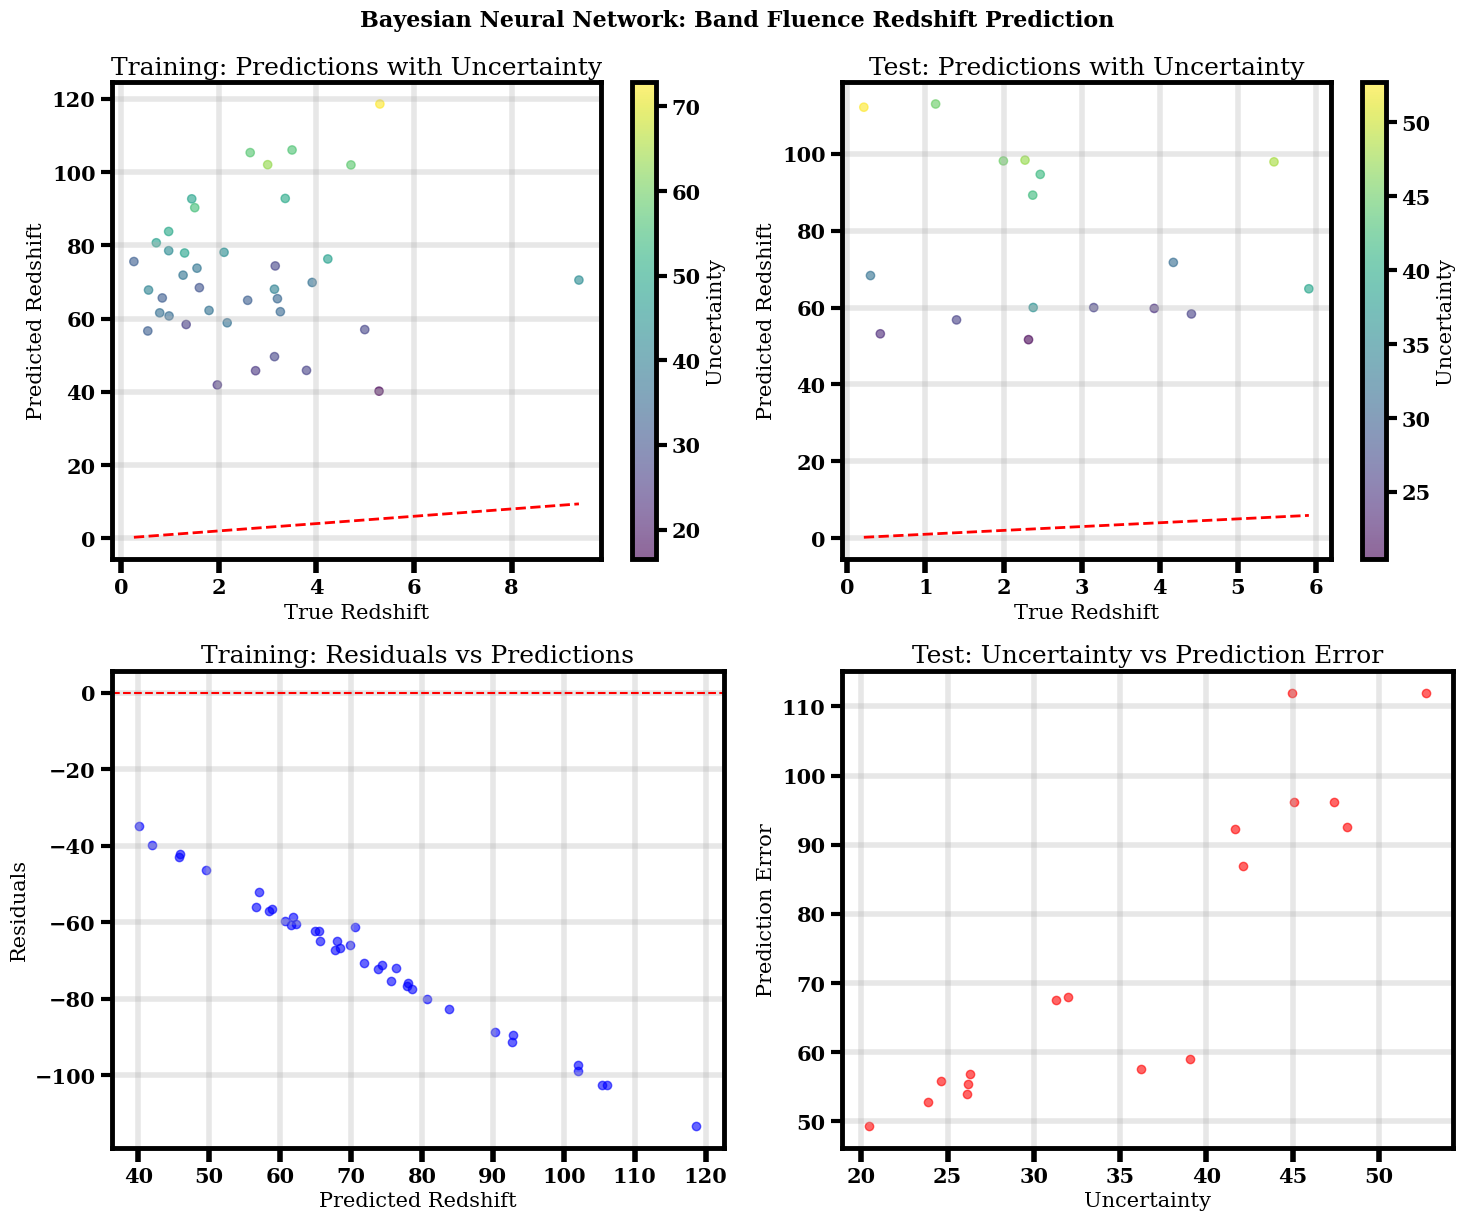


Applying model to extended dataset...
Making predictions on extended dataset...
Making predictions with model 1/3
Making predictions with model 2/3
Making predictions with model 3/3
Extended dataset size: 78
Pseudo-redshift range: 28.914 - 110.512
Mean uncertainty: 38.084


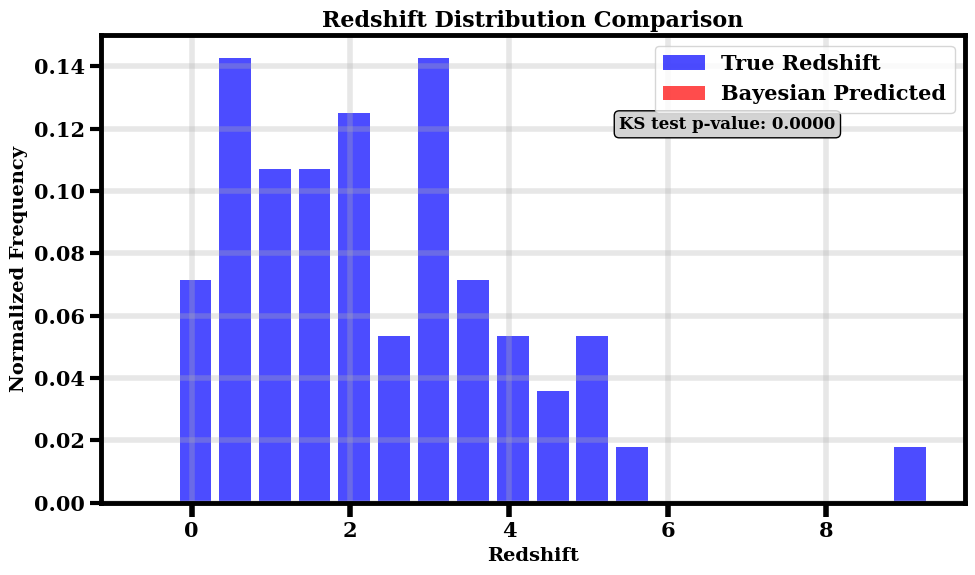

Kolmogorov-Smirnov Test p-value: 0.000000

Analysis completed successfully!
Files saved:
- BNN_Band_Fluence_Results_Fixed.png
- BNN_Redshift_Distribution_Comparison_Fixed.png
- bayesian_pseudo_redshift_bandflc_fixed.csv


In [3]:
"""Bayesian Neural Network for Band Fluence Redshift Prediction - FIXED VERSION

Complete implementation using TensorFlow Probability for uncertainty quantification
in gamma-ray burst redshift estimation.

IMPORTANT: This code requires Keras 2 (tf-keras) instead of Keras 3
Install: pip install tensorflow==2.15.0 tensorflow-probability tf-keras
"""

# Install required packages with Keras 2 compatibility
# pip install -q seaborn scikit-learn tensorflow==2.15.0 tensorflow-probability tf-keras openpyxl

import os
# CRITICAL: Set this before importing TensorFlow
os.environ["TF_USE_LEGACY_KERAS"] = "1"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from scipy.stats import kstest
import tensorflow as tf

# Use tf_keras instead of tf.keras for compatibility
try:
    import tf_keras as keras
    from tf_keras import layers
    print("Using tf_keras (Keras 2) for TensorFlow Probability compatibility")
except ImportError:
    # Fallback to regular Keras with legacy setting
    from tensorflow import keras
    from tensorflow.keras import layers
    print("Using tf.keras with legacy mode")

import tensorflow_probability as tfp
import warnings
warnings.filterwarnings('ignore')

# Configure TensorFlow Probability
tfd = tfp.distributions
tfpl = tfp.layers

print("TensorFlow version:", tf.__version__)
print("TensorFlow Probability version:", tfp.__version__)
print("Keras version:", keras.__version__ if hasattr(keras, '__version__') else "Unknown")

# Set matplotlib parameters
import matplotlib as mpl
font = {'family': 'serif', 'weight': 'bold', 'size': 15}
mpl.rc('font', **font)
mpl.rc('grid', linewidth=4)
mpl.rc('xtick.major', width=4, size=10)
mpl.rc('xtick.minor', width=3, size=4)
mpl.rc('ytick.major', width=3, size=8)
mpl.rc('ytick.minor', width=3, size=5)
mpl.rcParams['axes.linewidth'] = 3.5

# ============================================================================
# DATA LOADING AND PREPROCESSING
# ============================================================================

def load_and_preprocess_data():
    """Load and preprocess the Band Fluence dataset"""
    url = 'https://raw.githubusercontent.com/Adrita-Khan/GRB-ML/main/Data/kw_band_flc.xlsx'
    GBM_df = pd.read_excel(url)
    
    # Extract relevant columns
    columns = ['Redshift', 'T90', 'Alpha', 'Beta', 'Ep', 'Sbolo']
    GBM_df = GBM_df[columns]
    
    # Apply log transformation
    log_data = np.log10(GBM_df[['T90', 'Ep', 'Sbolo']])
    
    # Add spectral indices
    log_data['Alpha_flc'] = GBM_df['Alpha']
    log_data['Beta_flc'] = GBM_df['Beta']
    
    # Prepare features and target
    X = log_data
    y = GBM_df['Redshift']
    
    return X, y

# ============================================================================
# BAYESIAN NEURAL NETWORK COMPONENTS (FIXED FOR KERAS 2)
# ============================================================================

def posterior_mean_field(kernel_size, bias_size=0, dtype=None):
    """Create posterior distribution for Bayesian layers"""
    n = kernel_size + bias_size
    c = np.log(np.expm1(1.0))
    
    return keras.Sequential([
        tfpl.VariableLayer(2 * n, dtype=dtype),
        tfpl.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t[..., :n],
                      scale=1e-5 + tf.nn.softplus(c + t[..., n:])),
            reinterpreted_batch_ndims=1))
    ])

def prior_trainable(kernel_size, bias_size=0, dtype=None):
    """Create prior distribution for Bayesian layers"""
    n = kernel_size + bias_size
    
    return keras.Sequential([
        tfpl.VariableLayer(n, dtype=dtype, trainable=False),
        tfpl.DistributionLambda(lambda t: tfd.Independent(
            tfd.Normal(loc=t, scale=1.0),
            reinterpreted_batch_ndims=1))
    ])

def create_bayesian_model(input_shape, hidden_units, kl_weight):
    """Create a Bayesian Neural Network model using Keras 2 compatible layers"""
    
    # Use the Functional API for better compatibility
    inputs = keras.Input(shape=input_shape)
    x = inputs
    
    # Add Bayesian hidden layers
    for i, units in enumerate(hidden_units):
        x = tfpl.DenseVariational(
            units=units,
            make_posterior_fn=posterior_mean_field,
            make_prior_fn=prior_trainable,
            kl_weight=kl_weight,
            activation='relu',
            name=f'bayesian_dense_{i}'
        )(x)
    
    # Output layer - also Bayesian for epistemic uncertainty
    x = tfpl.DenseVariational(
        units=1,
        make_posterior_fn=posterior_mean_field,
        make_prior_fn=prior_trainable,
        kl_weight=kl_weight,
        name='bayesian_output'
    )(x)
    
    # Add aleatoric uncertainty through distributional output
    outputs = tfpl.DistributionLambda(
        lambda t: tfd.Normal(loc=t, scale=1e-3 + tf.nn.softplus(0.01 * t)),
        name='distribution_output'
    )(x)
    
    model = keras.Model(inputs=inputs, outputs=outputs, name='bayesian_neural_network')
    
    return model

# ============================================================================
# SIMPLIFIED BAYESIAN ENSEMBLE
# ============================================================================

class SimpleBayesianEnsemble:
    """Simplified ensemble of Bayesian Neural Networks with better error handling"""
    
    def __init__(self, model_configs):
        self.models = []
        self.model_configs = model_configs
        
    def create_models(self, input_shape, kl_weight):
        """Create ensemble of Bayesian models"""
        print("Creating Bayesian models...")
        for i, config in enumerate(self.model_configs):
            print(f"Creating model {i+1}/{len(self.model_configs)} with architecture: {config['hidden_units']}")
            try:
                model = create_bayesian_model(
                    input_shape=input_shape,
                    hidden_units=config['hidden_units'],
                    kl_weight=kl_weight
                )
                self.models.append(model)
                print(f"Model {i+1} created successfully")
            except Exception as e:
                print(f"Error creating model {i+1}: {e}")
                continue
    
    def compile_models(self, learning_rate=0.001):
        """Compile all models in the ensemble"""
        print("Compiling models...")
        for i, model in enumerate(self.models):
            model.compile(
                optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
                loss=lambda y, rv_y: -rv_y.log_prob(y),
                metrics=['mae']
            )
            print(f"Model {i+1} compiled")
    
    def fit_models(self, X_train, y_train, epochs=100, batch_size=32, verbose=0):
        """Train all models in the ensemble"""
        histories = []
        for i, model in enumerate(self.models):
            print(f"Training Bayesian model {i+1}/{len(self.models)}")
            try:
                history = model.fit(
                    X_train, y_train,
                    epochs=epochs,
                    batch_size=batch_size,
                    verbose=verbose,
                    validation_split=0.1
                )
                histories.append(history)
                print(f"Model {i+1} training completed")
            except Exception as e:
                print(f"Error training model {i+1}: {e}")
                continue
        return histories
    
    def predict_with_uncertainty(self, X, n_samples=50):
        """Predict with uncertainty quantification"""
        if not self.models:
            raise ValueError("No trained models available for prediction")
        
        ensemble_predictions = []
        
        for i, model in enumerate(self.models):
            print(f"Making predictions with model {i+1}/{len(self.models)}")
            try:
                # Multiple forward passes for each model
                model_predictions = []
                for _ in range(n_samples):
                    pred_dist = model(X, training=True)  # Enable stochastic behavior
                    pred_sample = pred_dist.mean()  # Use mean of distribution
                    model_predictions.append(pred_sample)
                
                model_predictions = tf.stack(model_predictions, axis=0)
                model_mean = tf.reduce_mean(model_predictions, axis=0)
                
                ensemble_predictions.append(model_mean)
            except Exception as e:
                print(f"Error making predictions with model {i+1}: {e}")
                continue
        
        if not ensemble_predictions:
            raise ValueError("No successful predictions from any model")
        
        # Combine ensemble predictions
        ensemble_predictions = tf.stack(ensemble_predictions, axis=0)
        
        # Final prediction and uncertainty
        final_prediction = tf.reduce_mean(ensemble_predictions, axis=0)
        uncertainty = tf.math.reduce_std(ensemble_predictions, axis=0)
        
        return final_prediction, uncertainty

# ============================================================================
# MAIN TRAINING AND EVALUATION (SIMPLIFIED)
# ============================================================================

def main():
    """Main training and evaluation pipeline"""
    
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X, y = load_and_preprocess_data()
    print(f"Dataset size: {len(y)} samples")
    
    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Convert to tensors
    X_train_tensor = tf.constant(X_train_scaled, dtype=tf.float32)
    X_test_tensor = tf.constant(X_test_scaled, dtype=tf.float32)
    y_train_tensor = tf.constant(y_train.values, dtype=tf.float32)
    
    # Define simplified model configurations for ensemble
    model_configs = [
        {'hidden_units': [64, 32]},
        {'hidden_units': [128, 64]},
        {'hidden_units': [96, 48, 24]}
    ]
    
    # Create and train Bayesian ensemble
    print("\nCreating Bayesian Neural Network ensemble...")
    kl_weight = 1.0 / len(X_train)  # KL divergence weight
    
    bayesian_ensemble = SimpleBayesianEnsemble(model_configs)
    bayesian_ensemble.create_models(
        input_shape=(X_train_scaled.shape[1],),
        kl_weight=kl_weight
    )
    
    if not bayesian_ensemble.models:
        raise ValueError("Failed to create any Bayesian models")
    
    bayesian_ensemble.compile_models(learning_rate=0.01)
    
    # Train ensemble
    print("Training Bayesian ensemble...")
    histories = bayesian_ensemble.fit_models(
        X_train_tensor, y_train_tensor,
        epochs=100,  # Reduced for faster training
        batch_size=32,
        verbose=1
    )
    
    # Make predictions with uncertainty
    print("\nMaking predictions with uncertainty quantification...")
    
    # Training predictions
    train_pred, train_uncertainty = bayesian_ensemble.predict_with_uncertainty(
        X_train_tensor, n_samples=30
    )
    
    # Test predictions
    test_pred, test_uncertainty = bayesian_ensemble.predict_with_uncertainty(
        X_test_tensor, n_samples=30
    )
    
    # Convert predictions to numpy
    train_pred_np = train_pred.numpy().flatten()
    test_pred_np = test_pred.numpy().flatten()
    train_uncertainty_np = train_uncertainty.numpy().flatten()
    test_uncertainty_np = test_uncertainty.numpy().flatten()
    
    # Evaluate performance
    print("\n" + "="*50)
    print("BAYESIAN NEURAL NETWORK RESULTS")
    print("="*50)
    
    # Training metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, train_pred_np))
    train_mae = mean_absolute_error(y_train, train_pred_np)
    train_r2 = r2_score(y_train, train_pred_np)
    
    print(f"Training - R²: {train_r2:.3f}, RMSE: {train_rmse:.3f}, MAE: {train_mae:.3f}")
    print(f"Training - Mean Uncertainty: {np.mean(train_uncertainty_np):.3f}")
    
    # Test metrics
    test_rmse = np.sqrt(mean_squared_error(y_test, test_pred_np))
    test_mae = mean_absolute_error(y_test, test_pred_np)
    test_r2 = r2_score(y_test, test_pred_np)
    
    print(f"Test - R²: {test_r2:.3f}, RMSE: {test_rmse:.3f}, MAE: {test_mae:.3f}")
    print(f"Test - Mean Uncertainty: {np.mean(test_uncertainty_np):.3f}")
    
    # Create prediction dataframes
    train_df = pd.DataFrame({
        'Actual': y_train.values,
        'Predicted': train_pred_np,
        'Uncertainty': train_uncertainty_np
    })
    
    test_df = pd.DataFrame({
        'Actual': y_test.values,
        'Predicted': test_pred_np,
        'Uncertainty': test_uncertainty_np
    })
    
    # Plotting
    plot_results(train_df, test_df)
    
    # Apply to new data
    print("\nApplying model to extended dataset...")
    try:
        apply_to_new_data(bayesian_ensemble, scaler)
    except Exception as e:
        print(f"Error applying to new data: {e}")
    
    return bayesian_ensemble, train_df, test_df

def plot_results(train_df, test_df):
    """Plot prediction results with uncertainty"""
    
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))
    
    # Training predictions with uncertainty
    scatter1 = axes[0,0].scatter(train_df['Actual'], train_df['Predicted'], 
                               c=train_df['Uncertainty'], cmap='viridis', alpha=0.6)
    axes[0,0].plot([train_df['Actual'].min(), train_df['Actual'].max()], 
                  [train_df['Actual'].min(), train_df['Actual'].max()], 'r--', lw=2)
    axes[0,0].set_xlabel('True Redshift')
    axes[0,0].set_ylabel('Predicted Redshift')
    axes[0,0].set_title('Training: Predictions with Uncertainty')
    axes[0,0].grid(True, alpha=0.3)
    plt.colorbar(scatter1, ax=axes[0,0], label='Uncertainty')
    
    # Test predictions with uncertainty
    scatter2 = axes[0,1].scatter(test_df['Actual'], test_df['Predicted'], 
                               c=test_df['Uncertainty'], cmap='viridis', alpha=0.6)
    axes[0,1].plot([test_df['Actual'].min(), test_df['Actual'].max()], 
                  [test_df['Actual'].min(), test_df['Actual'].max()], 'r--', lw=2)
    axes[0,1].set_xlabel('True Redshift')
    axes[0,1].set_ylabel('Predicted Redshift')
    axes[0,1].set_title('Test: Predictions with Uncertainty')
    axes[0,1].grid(True, alpha=0.3)
    plt.colorbar(scatter2, ax=axes[0,1], label='Uncertainty')
    
    # Residuals vs predictions (training)
    residuals_train = train_df['Actual'] - train_df['Predicted']
    axes[1,0].scatter(train_df['Predicted'], residuals_train, alpha=0.6, color='blue')
    axes[1,0].axhline(y=0, color='red', linestyle='--')
    axes[1,0].set_xlabel('Predicted Redshift')
    axes[1,0].set_ylabel('Residuals')
    axes[1,0].set_title('Training: Residuals vs Predictions')
    axes[1,0].grid(True, alpha=0.3)
    
    # Uncertainty vs prediction error (test)
    test_errors = np.abs(test_df['Actual'] - test_df['Predicted'])
    axes[1,1].scatter(test_df['Uncertainty'], test_errors, alpha=0.6, color='red')
    axes[1,1].set_xlabel('Uncertainty')
    axes[1,1].set_ylabel('Prediction Error')
    axes[1,1].set_title('Test: Uncertainty vs Prediction Error')
    axes[1,1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.suptitle('Bayesian Neural Network: Band Fluence Redshift Prediction', 
                 fontsize=16, fontweight='bold', y=1.02)
    plt.savefig('BNN_Band_Fluence_Results_Fixed.png', dpi=300, bbox_inches='tight')
    plt.show()

def apply_to_new_data(bayesian_ensemble, scaler):
    """Apply trained model to extended dataset"""
    
    try:
        # Load extended dataset
        url = 'https://github.com/Adrita-Khan/GRB-ML/raw/main/Data/kw_band_flc_flx.xlsx'
        Band_flc = pd.read_excel(url)
        
        # Remove rows with missing values
        Band_flc = Band_flc.dropna()
        
        # Filter for long GRBs
        Band_flc = Band_flc[Band_flc['T90'] >= 2.1]
        Band_flc = Band_flc[Band_flc['Beta'] <= -2]
        
        # Apply log transformation
        log_data = np.log10(Band_flc[['T90', 'Ep', 'Sbolo']])
        log_data['Alpha_flc'] = Band_flc['Alpha']
        log_data['Beta_flc'] = Band_flc['Beta']
        
        # Scale the data
        new_data_scaled = scaler.transform(log_data)
        new_data_tensor = tf.constant(new_data_scaled, dtype=tf.float32)
        
        # Make predictions with uncertainty
        print("Making predictions on extended dataset...")
        new_pred, new_uncertainty = bayesian_ensemble.predict_with_uncertainty(
            new_data_tensor, n_samples=30
        )
        
        # Convert to numpy
        pseudo_redshift = new_pred.numpy().flatten()
        pseudo_uncertainty = new_uncertainty.numpy().flatten()
        
        # Add results to dataframe
        Band_flc['pseudo_redshift'] = pseudo_redshift
        Band_flc['redshift_uncertainty'] = pseudo_uncertainty
        
        # Export results
        Band_flc.to_csv('bayesian_pseudo_redshift_bandflc_fixed.csv', index=False)
        
        print(f"Extended dataset size: {len(pseudo_redshift)}")
        print(f"Pseudo-redshift range: {pseudo_redshift.min():.3f} - {pseudo_redshift.max():.3f}")
        print(f"Mean uncertainty: {np.mean(pseudo_uncertainty):.3f}")
        
        # Compare distributions
        compare_distributions(pseudo_redshift)
        
        return Band_flc
        
    except Exception as e:
        print(f"Error processing extended dataset: {e}")
        return None

def compare_distributions(pseudo_red):
    """Compare true and predicted redshift distributions"""
    
    try:
        # Load original data for comparison
        url = 'https://raw.githubusercontent.com/Adrita-Khan/GRB-ML/main/Data/kw_band_flc.xlsx'
        GBM_df = pd.read_excel(url)
        true_redshifts = GBM_df['Redshift'].dropna()
        
        # Define bins
        xbin = [-0.5, 0, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7, 7.5, 8, 8.6, 9, 9.5]
        
        # Create normalized histograms
        heights_true, edges = np.histogram(true_redshifts, bins=xbin)
        heights_true = heights_true / heights_true.sum()
        
        heights_pred, _ = np.histogram(pseudo_red, bins=xbin)
        heights_pred = heights_pred / heights_pred.sum()
        
        # Plot comparison
        bin_centers = (edges[:-1] + edges[1:]) / 2
        
        plt.figure(figsize=(10, 6))
        plt.bar(bin_centers - 0.2, heights_true, width=0.4, alpha=0.7, 
                label='True Redshift', color='blue')
        plt.bar(bin_centers + 0.2, heights_pred, width=0.4, alpha=0.7, 
                label='Bayesian Predicted', color='red')
        
        plt.xlabel('Redshift', fontsize=14, fontweight='bold')
        plt.ylabel('Normalized Frequency', fontsize=14, fontweight='bold')
        plt.title('Redshift Distribution Comparison', fontsize=16, fontweight='bold')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Kolmogorov-Smirnov test
        _, p_value = kstest(heights_true, heights_pred)
        plt.text(0.6, 0.8, f'KS test p-value: {p_value:.4f}', 
                 transform=plt.gca().transAxes, fontsize=12, 
                 bbox=dict(boxstyle="round,pad=0.3", facecolor="lightgray"))
        
        plt.tight_layout()
        plt.savefig('BNN_Redshift_Distribution_Comparison_Fixed.png', dpi=300, bbox_inches='tight')
        plt.show()
        
        print(f'Kolmogorov-Smirnov Test p-value: {p_value:.6f}')
        
    except Exception as e:
        print(f"Error comparing distributions: {e}")

if __name__ == "__main__":
    print("Starting Bayesian Neural Network analysis for Band Fluence data...")
    print("Using Keras 2 compatible implementation")
    
    # Set random seeds for reproducibility
    np.random.seed(42)
    tf.random.set_seed(42)
    
    try:
        # Run main analysis
        ensemble, train_results, test_results = main()
        
        print("\nAnalysis completed successfully!")
        print("Files saved:")
        print("- BNN_Band_Fluence_Results_Fixed.png")
        print("- BNN_Redshift_Distribution_Comparison_Fixed.png") 
        print("- bayesian_pseudo_redshift_bandflc_fixed.csv")
        
    except Exception as e:
        print(f"Error during analysis: {e}")
        print("Please ensure you have the correct dependencies installed:")
        print("pip install tensorflow==2.15.0 tensorflow-probability tf-keras")